In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import notebook_setup

from copy import deepcopy
import pickle
import warnings
import os
# warnings.filterwarnings("error", category=UserWarning)
os.makedirs(os.path.expanduser('~/Data/tensorboard/'), exist_ok=True)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer, r2_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from pytorchbridge import TorchEstimator
from joblib import Parallel, delayed

from utils import (cache_function, cache_to_episodic_rewards,
                   cache_to_episodes, copy_tensor, copy_mlp_regressor,
                   sanitize_filename)
from ppo import PPO, Memory, ActorCriticDiscrete
from meta import learn_env_model, meta_update, kl_div, prune_library, plot_adaption
from systems import CartPoleEnv, CartPoleDataEnv, plot_cartpole

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 0
NCPU = os.cpu_count() // 2

## System

In [16]:
env_name = 'CartPole-v1'
env = CartPoleEnv()
PhysicalEnv = CartPoleEnv
DataEnv = CartPoleDataEnv
nominal_config = dict(
    masscart=1.0,
    masspole=0.1,
    length=1.0,
    force_mag=10.0,
    tau=0.2
)
env_fn = lambda: PhysicalEnv()

### System model

* TODO: Check if training data tuples are actually causal

In [4]:
# Generate training data
def generate_training_data(env, episodes=50):
    Xtrain, Ytrain = [], []
    x = env.reset()
    e = 0
    while e < episodes:
        u = env.action_space.sample()
        Xtrain.append(np.concatenate((x, (u,))))
        x, _, done, _ = env.step(u)
        Ytrain.append(x)
        if done:
            e += 1
            x = env.reset()
    return np.asarray(Xtrain, dtype=np.float32), np.asarray(Ytrain, dtype=np.float32)

Xtrain, Ytrain = generate_training_data(env, episodes=50)
print(Xtrain.shape, Ytrain.shape)

(1227, 5) (1227, 4)


In [ ]:
grid = GridSearchCV(MLPRegressor(), scoring=make_scorer(r2_score, multioutput='uniform_average'),
                   param_grid={
                       'hidden_layer_sizes': ((32, 32), (64, 64)),
                       'activation': ('relu', 'logistic'),
                       'learning_rate_init': (1e-2, 1e-3),
                       'warm_start': (True,)
                   },
                   n_jobs=12, verbose=1)
grid.fit(Xtrain, Ytrain)
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score', ascending=True, axis=0).head()

In [ ]:
# Train on episodes-1, validate on 1 episode worth of instances:
est = grid.best_estimator_
# Plot performance

plot_cartpole(CartPoleDataEnv(env, est))
plt.suptitle('');

In [ ]:
module = nn.Sequential(
    nn.Linear(12, 64),
    nn.Tanh(),
    nn.Linear(64, 6),
    nn.Sigmoid()
)
o = optim.Adam(module.parameters(), lr=50e-5)
l = nn.MSELoss()
e = TorchEstimator(module, o, l, epochs=100, batch_size=32, early_stopping=True, verbose=True, max_tol_iter=10, tol=1e-5)
e.fit(Xtrain, Ytrain);
est=e # replace scklearn's estimator with pyTorch

### Degradation

In [23]:
def degrade(env, factor, **nominal):
    if isinstance(factor, (int, float)):
        factor = np.ones(len(nominal)) * factor
    else:
        factor = np.asarray(factor)
    params = {k: v*(1+f) for (k, v), f in zip(nominal.items(), factor)}
    env.set_parameters(**params)


def random_degrade(env=None, factors=(-0.75, 0.75), random=np.random, **nominal):
    factors = random.rand(len(nominal)) * (factors[1] - factors[0]) + factors[0]
    if env is not None:
        degrade(env, factor, **nominal)
    return factors

## Complementary MAML

In [34]:
env = env_fn()
timesteps = 100000            # max timesteps in one episode

ppo_params = dict(
    state_dim = env.observation_space.shape[0],
    action_dim = 2,
    policy=ActorCriticDiscrete,
    epochs = 5,                  # update policy for K epochs
    lr = 0.01,                  # learning rate
    n_latent_var = 32,           # number of variables in hidden layer
    betas = (0.9, 0.999),
    gamma = 0.99,                # discount factor
    eps_clip = 0.2,              # clip parameter for PPO
    update_interval = 1000      # update policy every n timesteps
)
library_size = 3
data_model = False

In [35]:
# Nominal agent trained without fault
agent = PPO(env, **ppo_params)
r = agent.learn(timesteps)
library = [copy_tensor(agent.policy.state_dict())]   # initialize library with policy
plt.scatter(np.arange(len(r), r))
plt.title('Rewards on system under nominal conditions');

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [ ]:
# Populate library of policies
library_rewards = []
del library[1:]

factors = [random_degrade(**nominal_config) for _ in range(3)]

for factor in tqdm(factors, total=len(factors), leave=False):
    env_ = env_fn()
    # introduce some fault and learn data-driven model
    degrade(env_, factor, **nominal_config)
    if data_model:
        est_ = copy_mlp_regressor(est)  # copy estimator hyperparameters etc.
        x, y = generate_training_data(env_, episodes=50)  # random actions!
        est_.fit(x, y)
        # Train agent on data-driven model
        env_ = DataEnv(env_, est_)
    agent_ = PPO(env_, **ppo_params)
    rewards = agent_.learn(30000)
    library.append(copy_tensor(agent_.policy.state_dict()))
    library_rewards.append(rewards)

# PLot library rewards
plt.figure(figsize=(10, 8))
for i, rewards in enumerate(library_rewards):
    plt.plot(rewards, label='Policy#{}'.format(i))
plt.title('Episodic rewards on model with faults')
plt.legend()
plt.grid(True, 'both')

pth = './bin/library/'
os.makedirs(pth, exist_ok=True)
plt.savefig(pth+env_name+'_library_rewards.png')
with open(pth + 'lib_rwards.pickle', 'wb') as f:
    pickle.dump(dict(library_rewards=library_rewards, factors=factors), f)

### Experiment functions

In [29]:
def adapt(agent, est, memory, library, data_model=True,
          n_inner=1, n_outer=1, alpha_inner=0.01, alpha_outer=0.1,
          **ppo_params):
    if data_model:
        est_ = learn_env_model(memory, est)
        env_ = DataEnv(agent.env, est_)
    else:
        env_ = agent.env
    params = meta_update(agent.policy.state_dict(), env_, library, memory,
                         n_inner, n_outer, alpha_inner, alpha_outer,
                         data_model, **ppo_params)
    agent.policy.load_state_dict(params)
    return agent

def adapt_benchmark(agent, est, memory, library, data_model=True,
          n_inner=1, n_outer=1, alpha_inner=0.01, alpha_outer=0.1,
          **ppo_params):
    if data_model:
        est_ = learn_env_model(memory, est)
        env_ = DataEnv(agent.env, est_)
    else:
        env_ = agent.env
    agent.learn(ppo_params['update_interval'], ppo_params['update_interval'])
    env_backup = agent.env
    agent.env = env_
    # If data_model, then interact for the same number of times with the data env
    # as the meta-update step does in the outer x inner loops. Otherwise, reuse
    # the buffered memory for the same number of times as the meta update step.
    if data_model:
        agent.learn(timesteps=ppo_params['update_interval'] * (len(library) * n_inner * n_outer),
                    update_interval=ppo_params['update_interval'])
    else:
        pass
        # agent.update(policy=agent.policy, memory=memory,
        #              epochs=len(library) * n_inner * n_outer, optimizer=agent.optimizer)
    agent.env = env_backup
    return agent

In [30]:
def trial(env_, est, starting_policy, library=[], data_model=True, post_steps=10000,
          n_inner=1, n_outer=1, alpha_inner=0.01, alpha_outer=0.1,
          benchmark=True):
    # Make copies of env, and agent trained on nominal system,
    # and starting library of policies (if any)
    agent_ = PPO(env_, **ppo_params)
    agent_.policy.load_state_dict(copy_tensor(starting_policy))
    if benchmark:
        agent_benchmark = PPO(env_, **ppo_params)
        agent_benchmark.policy.load_state_dict(copy_tensor(starting_policy))
    library_ = [copy_tensor(p) for p in library]
    # Fault occurs, buffer experience with environment
    memory_ = Memory()
    agent_.experience(memory_, ppo_params['update_interval'], env_, agent_.policy)
    # Use meta-learning to adapt to fault
    adapt(agent_, est, memory_, library_, data_model,
          n_inner, n_outer, alpha_inner, alpha_outer, **ppo_params)
    if benchmark:
        adapt_benchmark(agent_benchmark, est, memory_, library_, data_model,
                        n_inner, n_outer, alpha_inner, alpha_outer, **ppo_params)
    # Continue learning
    rewards = []
    agents = [agent_, agent_benchmark] if benchmark else [agent_]
    for a in tqdm(agents, desc='Post-fault training', leave=False):
        rewards.append(a.learn(post_steps))
    return rewards, agent_.policy.state_dict(), memory_

# TODO: Why do trials return different number of episodes, why is mean and std of different length
def ntrials(n=NCPU, verbose=10, *trial_args, **trial_kwargs):
    res = Parallel(n_jobs=min(n, NCPU), verbose=verbose)(
        delayed(trial)(*trial_args, **trial_kwargs) for _ in range(n)
    )
    benchmark = len(res[0][0])==2
    minlen = min([len(r[0][0]) for r in res])  # in case number of episodes / trial is different
    rewards = np.asarray([r[0][0][:minlen] for r in res]) # list of episodic rewards from each trial
    mean = np.mean(rewards, axis=0)
    std = np.std(rewards, axis=0)
    if benchmark:
        minlen = min([len(r[0][1]) for r in res])  # in case number of episodes / trial is different
        rewards_benchmark = np.asarray([r[0][1][:minlen] for r in res])
        mean_benchmark = np.mean(rewards_benchmark, axis=0)
        std_benchmark = np.std(rewards_benchmark, axis=0)
    else:
        mean_benchmark = None
        std_benchmark = None
    return (mean, mean_benchmark), (std, std_benchmark)

### Grid-search

In [ ]:
grid = ParameterGrid(dict(
    alpha_inner = [1e-3, 1e-2],
    alpha_outer = [1e-2, 1e-1],
    n_inner = [4],
    n_outer = [2],
    data_model = [False, True],
    post_steps = [30000],
    library = [[], library]
))
os.makedirs(('./bin/hyperparameters'), exist_ok=True)

tanks_ = TanksFactory(n = n_tanks, e = n_engines, **nominal_config)
env_ = TanksPhysicalEnv(tanks_, tstep)
factors = random_degrade(tanks_, atmost_engines=1)
print('Tank Factors:', factors[0])
print('Engine Factors:', factors[1])

hyp_r, hyp_std, hyp_rb, hyp_stdb = [], [], [], []
ngrid = 0
for trial_params in tqdm(grid, desc='Hyperparameters', leave=False):
    (r, r_b), (std, std_b) = ntrials(4, 11, env_, est, agent.policy.state_dict(), **trial_params)
    hyp_r.append(r)
    hyp_rb.append(r_b)
    hyp_std.append(std)
    hyp_stdb.append(std_b)
    ngrid += 1   

In [ ]:
ncol = 2
nrow = ngrid // ncol + (ngrid % ncol != 0)
plt.figure(figsize=(12, 3 * nrow))
for i, (grid_params, (r, r_b, std, std_b)) in enumerate(zip(grid, zip(hyp_r, hyp_rb, hyp_std, hyp_stdb))):
    plt.subplot(nrow, ncol, i + 1)
    plot_adaption(r, r_b, std, std_b)
    print([(k, len(v) if k=='library' else v) for k, v in grid_params.items() if k not in ['post_steps']])
    plt.title(i)
plt.tight_layout()

### Populated vs. empty policy library

Factors: [ 0.08281129 -0.41969988 -0.03780989 -0.09110655  0.70186209]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  4.5min remaining:  4.5min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  4.6min finished


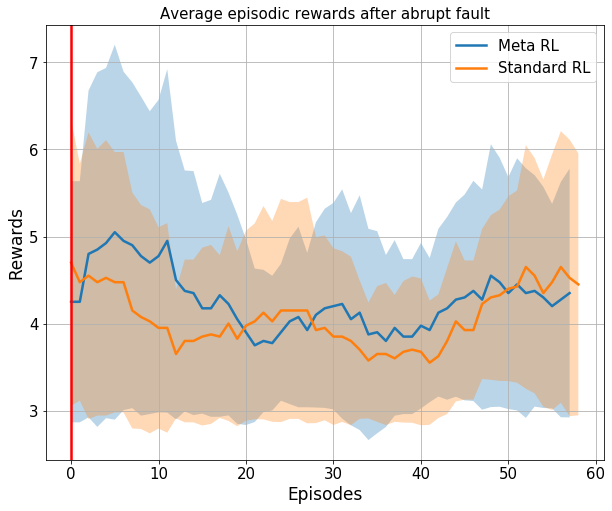

In [31]:
trial_params = dict(
    alpha_inner = 1e-3,
    alpha_outer = 1e-2,
    n_inner = 4,
    n_outer = 2,
    data_model = True,
    post_steps = 30000
)
pth = './bin/populated_vs_empty_library/'
os.makedirs(pth, exist_ok=True)

env_ = env_fn()
factors = random_degrade(env_, **nominal_config)
# degrade(env_, factors, **nominal_config)
print('Factors:', factors)

(r, r_b), (std, std_b) = ntrials(4, 20, env_, est, agent.policy.state_dict(), library, **trial_params)

plt.figure(figsize=(10,8))
plot_adaption(r, r_b, std, std_b);

fname = pth + env_name + 'libsize_3_f' + sanitize_filename(str(factors) + str(trial_params))
plt.savefig(fname + '.png')
with open(fname+'.pickle', 'wb') as f:
    pickle.dump(dict(trial_params=trial_params, results=(r, r_b, std, std_b), factors=factors), f)

In [ ]:
# Empty library
(r, r_b), (std, std_b) = ntrials(4, 20, env_, est, agent.policy.state_dict(), [], **trial_params)

plt.figure(figsize=(10,8))
plot_adaption(r, r_b, std, std_b);

fname = pth + env_name + 'libsize_3_f' + sanitize_filename(str(factors) + str(trial_params))
plt.savefig(fname + '.png')
with open(fname+'.pickle', 'wb') as f:
    pickle.dump(dict(trial_params=trial_params, results=(r, r_b, std, std_b), factors=factors), f);

### Sequential abrupt faults

In [ ]:
# Multi-fault trial
multi_trial_params = dict(
    starting_policy = agent.policy.state_dict(),
    n_faults = 10,
    lib_size = 3,
    library=[]
)
trial_params = dict(
    alpha_inner = 1e-3,
    alpha_outer = 1e-3,
    n_inner = 4,
    n_outer = 1,
    data_model = False,
    post_steps = 30000
)

def multi_trial(starting_policy, n_faults=5, lib_size=3, library=[], **trial_params):
    tanks_ = TanksFactory(n = n_tanks, e = n_engines, **nominal_config)
    env_ = TanksPhysicalEnv(tanks_, tstep)
    agent_ = PPO(env_, **ppo_params)
    agent_.policy.load_state_dict(copy_tensor(starting_policy))
    rewards = []
    rewards_benchmark = []
    fault_times = [0]
    for f in trange(n_faults, desc='Faults', leave=False):
        factors = random_degrade(tanks_)
        rew, params, memory = trial(env_, est, agent_.policy.state_dict(), library, **trial_params)
        library.append(params)
        library, div = prune_library(library, lib_size, memory, **ppo_params)
        agent_.policy.load_state_dict(params)
        rewards.extend(rew[0])
        rewards_benchmark.extend(rew[1])
        fault_times.append(fault_times[-1] + len(rew[0]))
    return rewards, rewards_benchmark, fault_times[:-1]

def nmulti_trials(n=NCPU, verbose=20, **params):
    res = Parallel(n_jobs=min(n, NCPU), verbose=verbose)(
        delayed(multi_trial)(**params) for _ in range(n)
    )
    benchmark = res[0][1] is not None
    minlen = min([len(r[0]) for r in res])  # in case number of episodes / trial is different
    rewards = np.asarray([r[0][:minlen] for r in res]) # list of episodic rewards from each trial
    mean = np.mean(rewards, axis=0)
    std = np.std(rewards, axis=0)
    # Benchmarks
    if benchmark:
        minlen = min([len(r[1]) for r in res])  # in case number of episodes / trial is different
        rewards_benchmark = np.asarray([r[1][:minlen] for r in res])
        mean_benchmark = np.mean(rewards_benchmark, axis=0)
        std_benchmark = np.std(rewards_benchmark, axis=0)
    else:
        mean_benchmark = None
        std_benchmark = None
    # Faults
    minlen = min([len(r[2]) for r in res])  # in case number of episodes / trial is different
    fault_times = np.asarray([r[2][:minlen] for r in res]) # list of episodic rewards from each trial
    fault_times = np.mean(fault_times, axis=0)
    return (mean, mean_benchmark), (std, std_benchmark), fault_times

(r, r_b), (std, std_b), f = nmulti_trials(n=4, verbose=20, **multi_trial_params, **trial_params)

In [ ]:
pth = './bin/multi_fault/'
os.makedirs(pth, exist_ok=True)

plt.figure(figsize=(15, 6))
plot_adaption(r, r_b, std, std_b, f)

fname = pth + sanitize_filename(str({k:v for k, v in multi_trial_params.items() \
                                     if k not in ('library', 'starting_policy')}) + str(trial_params))
plt.savefig(fname + '.png')
with open(fname+'.pickle', 'wb') as fi:
    pickle.dump(dict(trial_params=trial_params, multi_trial_params=multi_trial_params,
                     results=(r, r_b, std, std_b, f)), fi);